<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                20000 non-null  object 
 1   Segment                   20000 non-null  object 
 2   Age                       20000 non-null  int64  
 3   Country                   20000 non-null  object 
 4   Plan                      20000 non-null  object 
 5   ContractType              20000 non-null  object 
 6   AutoRenew                 20000 non-null  int64  
 7   TenureMonths              20000 non-null  float64
 8   MonthlyCharges            20000 non-null  float64
 9   Upgrades                  20000 non-null  int64  
 10  Downgrades                20000 non-null  int64  
 11  IsPromoEligible           20000 non-null  int64  
 12  LoginsLast30d             20000 non-null  int64  
 13  SessionsPerUserLastMonth  20000 non-null  float64
 14  PeakUs

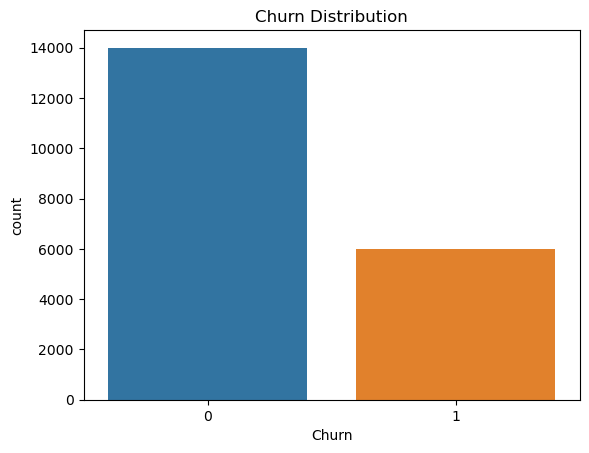

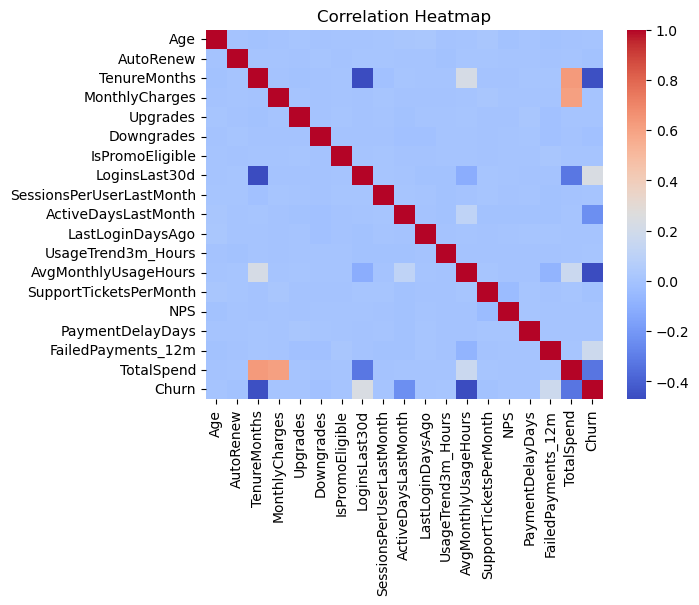

In [112]:
# Load Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\mrahu\Desktop\synthetic_churn_dataset_20000_.csv")

# Basic checks
print(df.info())
print(df.isnull().sum())

# Churn distribution
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()


# Correlation heatmap (numerical features)
numeric_cols = df.select_dtypes(include="number").columns
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [113]:
# Derived features
df["SupportTicketsPerMonth"] = df["SupportTicketsPerMonth"] / (df["TenureMonths"]+1)
df["AvgTimeBetweenLogins"] = df["LastLoginDaysAgo"] / (df["LoginsLast30d"]+1)

# Drop leakage / non-predictive
X = df.drop(columns=["CustomerID", "Churn", "Age", "Country", "Segment","TenureMonths"])
y = df["Churn"]

# Encode categoricals
from sklearn.preprocessing import LabelEncoder
cat_cols = X.select_dtypes(include="object").columns
print(cat_cols)
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X.head(30)


Index(['Plan', 'ContractType', 'PeakUsageTimeOfDay'], dtype='object')


,Plan,ContractType,AutoRenew,MonthlyCharges,Upgrades,Downgrades,IsPromoEligible,LoginsLast30d,SessionsPerUserLastMonth,PeakUsageTimeOfDay,ActiveDaysLastMonth,LastLoginDaysAgo,UsageTrend3m_Hours,AvgMonthlyUsageHours,SupportTicketsPerMonth,NPS,PaymentDelayDays,FailedPayments_12m,TotalSpend,AvgTimeBetweenLogins
0,2,2,1,162.79,0,0,0,19,8.0,0,19,15,9.6,147.421086,0.032488,13,5,2,7271.85,0.750000
1,2,1,1,124.70,1,0,1,19,4.2,1,11,32,7.5,142.611979,0.000000,27,1,0,3552.05,1.600000
2,0,1,1,111.67,1,0,1,30,2.5,3,7,23,13.3,10.023203,0.000000,-99,5,2,133.52,0.741935
3,2,1,1,173.96,0,0,1,19,5.8,3,15,26,99.2,24.065154,0.000000,-20,3,3,5995.42,1.300000
4,2,2,1,182.96,0,0,1,18,1.6,0,16,27,114.3,18.501464,0.058099,0,1,0,11602.74,1.421053
5,0,2,1,34.45,0,0,0,30,0.5,0,11,43,52.9,87.463634,0.538759,55,3,3,197.21,1.387097
6,2,1,1,140.64,0,0,1,24,7.2,2,15,42,109.6,34.074778,0.027164,41,6,0,3563.07,1.680000
7,0,1,0,60.98,0,1,1,19,8.4,1,8,20,49.2,1.001839,0.749369,37,2,4,949.94,1.000000
8,0,2,0,158.28,0,0,0,22,8.5,3,30,0,172.1,76.836473,0.021244,-5,0,3,7786.26,0.000000
9,0,1,1,32.19,1,0,0,14,9.9,0,20,18,78.4,191.834939,0.030931,-26,2,0,985.53,1.200000


In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models + params
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000),
        "params": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [5, 10, None]}
    },
    "Extra Trees": {
        "model": ExtraTreesClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [5, 10, None]}
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1, 0.3], "max_depth": [3, 5, 7]}
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1, 0.3], "max_depth": [-1, 5, 7]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7, 11]}
    }
}


In [115]:
results = []
best_models = {}

for name, mp in param_grids.items():
    grid = GridSearchCV(mp["model"], mp["params"], scoring="f1", cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append([name, grid.best_params_, acc, f1, auc])
    print(f"\n{name} Report\n", classification_report(y_test, y_pred))





Logistic Regression Report
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      2800
           1       0.79      0.70      0.74      1200

    accuracy                           0.85      4000
   macro avg       0.83      0.81      0.82      4000
weighted avg       0.85      0.85      0.85      4000


Decision Tree Report
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      2800
           1       0.90      0.88      0.89      1200

    accuracy                           0.94      4000
   macro avg       0.93      0.92      0.92      4000
weighted avg       0.94      0.94      0.94      4000


Random Forest Report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2800
           1       0.91      0.91      0.91      1200

    accuracy                           0.95      4000
   macro avg       0.94      0.94      0.94      4000

In [116]:
results_df = pd.DataFrame(results, columns=["Model", "Best Params", "Accuracy", "F1 Score", "ROC-AUC"])
results_df = results_df.sort_values(by=["F1 Score", "ROC-AUC"], ascending=False)
results_df

,Model,Best Params,Accuracy,F1 Score,ROC-AUC
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.95050,0.917569,0.984222
4,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.94925,0.915311,0.984305
7,LightGBM,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.94900,0.914501,0.984009
2,Random Forest,"{'max_depth': None, 'n_estimators': 200}",0.94725,0.911900,0.980839
1,Decision Tree,"{'max_depth': 10, 'min_samples_split': 10}",0.93575,0.891789,0.959494
5,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 200}",0.93550,0.891779,0.979296
3,Extra Trees,"{'max_depth': None, 'n_estimators': 200}",0.93150,0.881385,0.977628
0,Logistic Regression,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.85400,0.742277,0.920350
8,KNN,{'n_neighbors': 7},0.82450,0.642930,0.888948


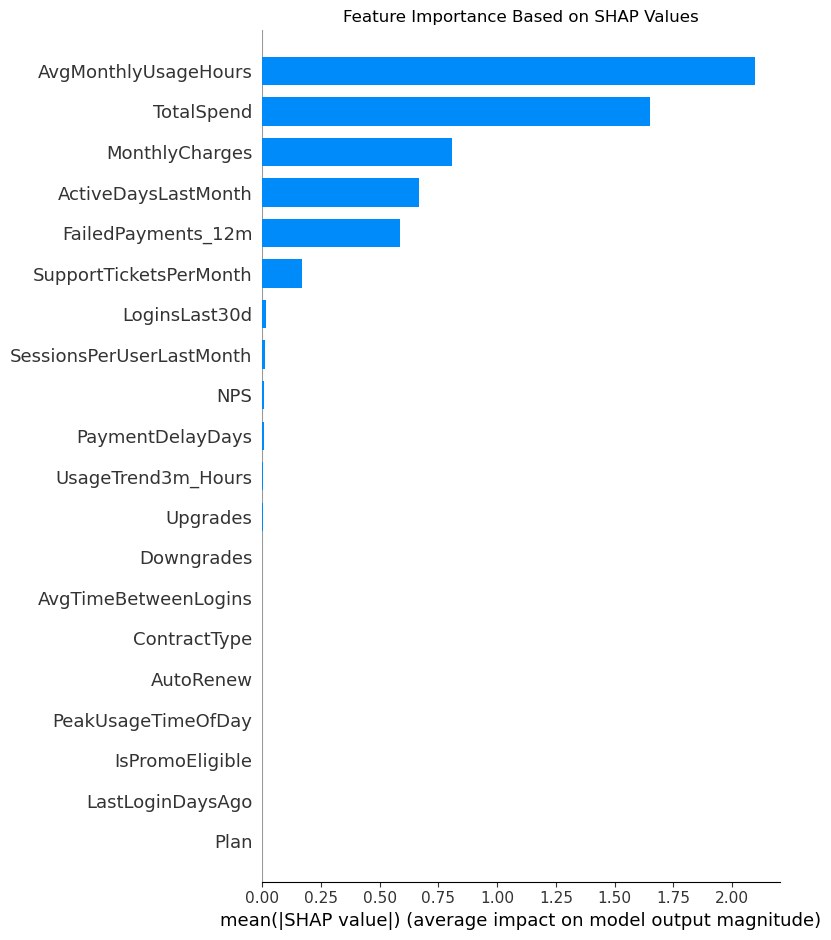

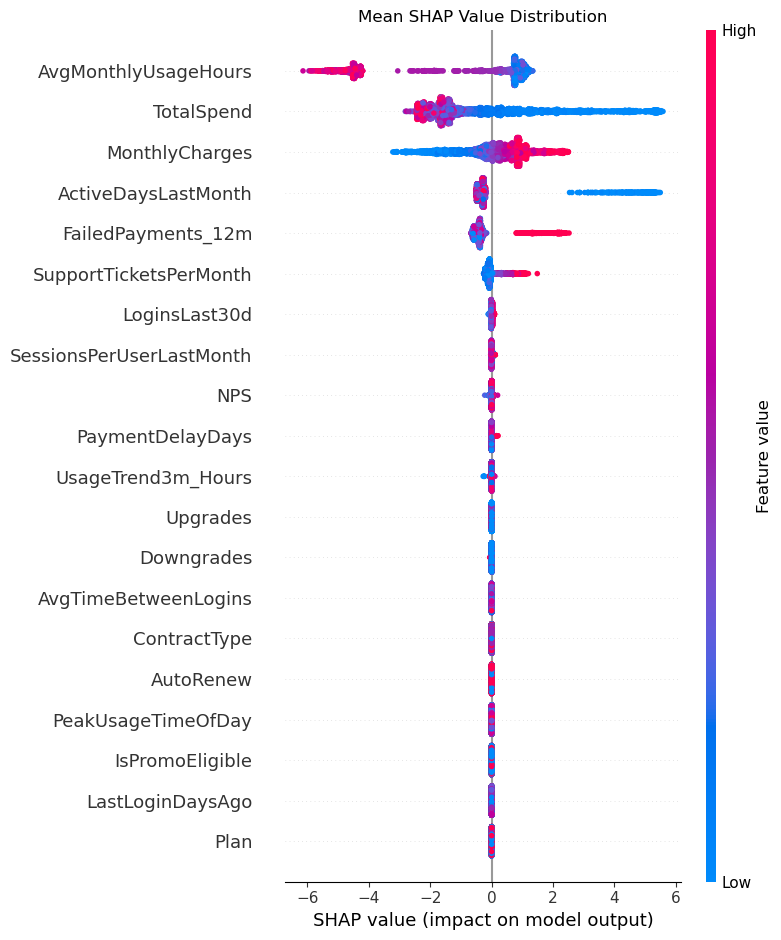

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

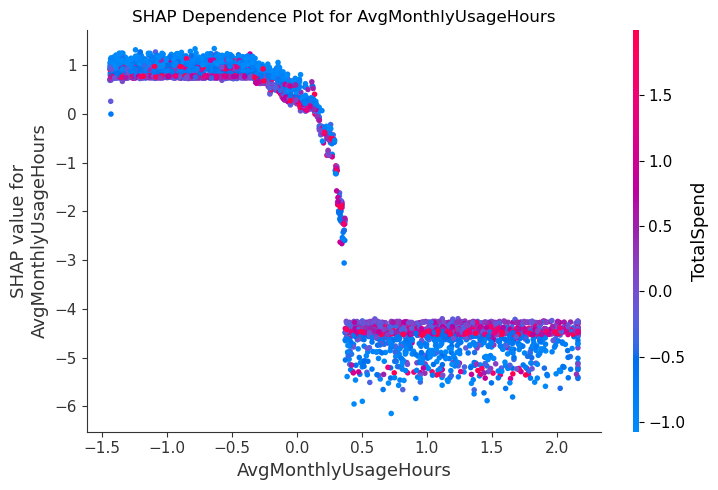

In [130]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Set the matplotlib backend to inline for proper display
%matplotlib inline

# Initialize SHAP explainer with the best model
best_model = best_models["XGBoost"]
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Handle different SHAP return formats
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use values for positive class (churn)

# Get base value - handle both scalar and array cases
if hasattr(explainer.expected_value, '__len__') and len(explainer.expected_value) > 1:
    base_value = explainer.expected_value[1]  # Use base value for positive class
else:
    base_value = explainer.expected_value  # Single value

# 1. Feature Importance Plot (Bar Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Feature Importance Based on SHAP Values")
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Mean SHAP Value Plot (Beeswarm Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("Mean SHAP Value Distribution")
plt.tight_layout()
plt.savefig('mean_shap_values.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Waterfall Plot for a Specific Instance
# Select an instance to explain
instance_idx = 0  # First test instance

# Create an Explanation object for the waterfall plot
explanation = shap.Explanation(
    values=shap_values[instance_idx],
    base_values=base_value,
    data=X_test[instance_idx],
    feature_names=X.columns
)

plt.figure(figsize=(12, 8))


# 4. Dependence Plot for the Most Important Feature
# Find the most important feature
feature_importance = np.abs(shap_values).mean(0)
most_important_feature = X.columns[np.argmax(feature_importance)]

plt.figure(figsize=(10, 8))
shap.dependence_plot(most_important_feature, shap_values, X_test, feature_names=X.columns, show=False)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.savefig('dependence_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [127]:
import pandas as pd
import numpy as np

def explain_customer(instance_idx, threshold=0.5):
    """
    Explain churn prediction for one customer (from full dataset df)
    """
    # Scale the full dataset if not already done
    X_scaled = scaler.transform(X)  

    # 1. Get prediction for the chosen customer
    prob = best_model.predict_proba(X_scaled[instance_idx:instance_idx+1])[0][1]
    prediction = "Churn" if prob > threshold else "Not Churn"
    actual = "Churn" if y.iloc[instance_idx] == 1 else "Not Churn"

    # 2. Compute SHAP values for the full dataset (once)
    shap_values_full = explainer.shap_values(X_scaled)

    # 3. Get SHAP values for this customer
    contributions = shap_values_full[instance_idx]

    # 4. Pair feature names, values, and contributions
    details = []
    for feature, value, contrib in zip(X.columns, X_scaled[instance_idx], contributions):
        details.append((feature, value, contrib))

    # 5. Sort by absolute contribution
    details = sorted(details, key=lambda x: abs(x[2]), reverse=True)

    # 6. Print explanation
    print("="*60)
    print(f"Customer ID: {df.iloc[instance_idx]['CustomerID'] if 'CustomerID' in df.columns else 'N/A'}")
    print(f"Prediction: {prediction} (Probability: {prob:.2f})")
    print(f"Actual: {actual}\n")
    print("Top 5 factors influencing this prediction:")

    for i, (feature, value, contrib) in enumerate(details[:5], 1):
        direction = "↑ Increases churn" if contrib > 0 else "↓ Decreases churn"
        print(f"{i}. {feature} = {value:.2f} ({direction}, impact {abs(contrib):.3f})")

    print("\nActionable Insights:")
    for feature, value, contrib in details[:3]:
        if contrib > 0:
            print(f"- Reduce risk from {feature} (current: {value:.2f})")
        else:
            print(f"- Maintain strength in {feature} (current: {value:.2f})")
    print("="*60)

    # 7. SHAP Waterfall plot
    explanation = shap.Explanation(
        values=contributions,
        base_values=explainer.expected_value,
        data=X_scaled[instance_idx],
        feature_names=X.columns
    )
    shap.plots.waterfall(explanation, max_display=10)


Customer ID: C06000
Prediction: Not Churn (Probability: 0.00)
Actual: Not Churn

Top 5 factors influencing this prediction:
1. AvgMonthlyUsageHours = 1.30 (↓ Decreases churn, impact 5.364)
2. FailedPayments_12m = 1.65 (↑ Increases churn, impact 1.314)
3. TotalSpend = 1.37 (↓ Decreases churn, impact 1.262)
4. MonthlyCharges = 1.35 (↑ Increases churn, impact 0.602)
5. ActiveDaysLastMonth = -1.42 (↓ Decreases churn, impact 0.226)

Actionable Insights:
- Maintain strength in AvgMonthlyUsageHours (current: 1.30)
- Reduce risk from FailedPayments_12m (current: 1.65)
- Maintain strength in TotalSpend (current: 1.37)


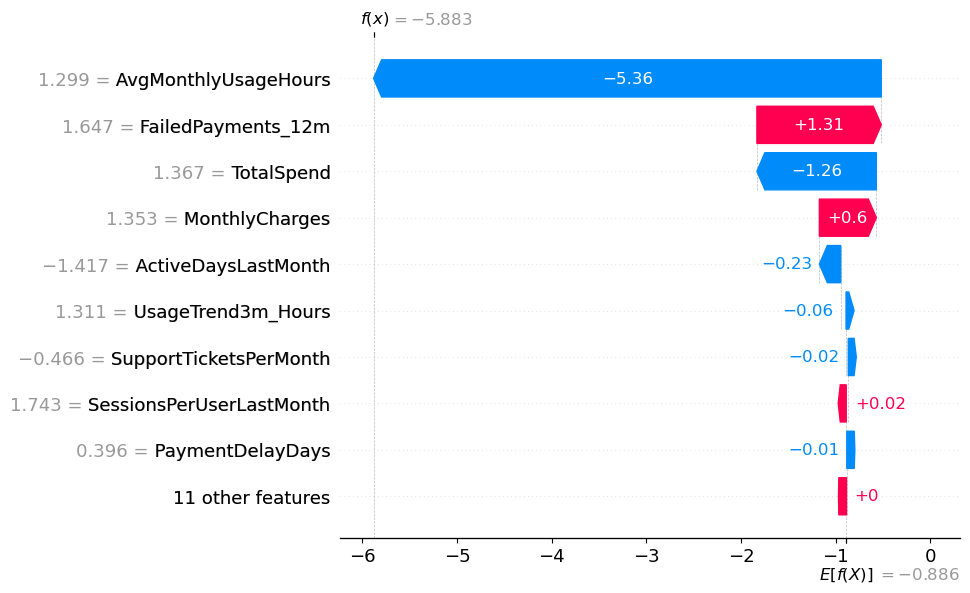

In [129]:
explain_customer(5999)